In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import keras
from keras import metrics
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
import os
import pickle
import cv2
import imutils
from imutils.contours import sort_contours
from keras.layers import Dropout

# from src import fonctions

Using TensorFlow backend.


In [2]:
# Chemins du projet
DATA_ROOT = 'data/'
MODELE_PATH = DATA_ROOT + 'model.h5'
TRAINING_PATH = DATA_ROOT + 'train'
TESTING_PATH = DATA_ROOT + 'test'

# Autres paramètres
batch_size = 32
num_classes = 32
epochs = 35
# img_size = 28
img_size = 32
input_shape = (img_size, img_size, 3)
validation_split = 0.3

In [3]:
# fonctions.import_fichier_train()

In [4]:
# fonctions.import_fichier_test()

In [5]:


### ImageDataGenerator génère des lots de données d'image vectorielles, convertissant les coefficients RVB compris entre 0 et 255 en valeurs cibles comprises entre 0 et 1 par mise à l'échelle avec un facteur de 1/255 à l' aide de la remise à l' échelle ###

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    ### shear_range est utilisé pour appliquer de manière aléatoire des transformations de cisaillement ###
    # shear_range = 0.1,
    ### zoom_range est utilisé pour zoomer aléatoirement à l'intérieur des images ###           
    # zoom_range = 0.1,
    ### horizontal_flip est utilisé pour retourner au hasard la moitié des images horizontalement ###            
    horizontal_flip = True
)      

test_datagen = ImageDataGenerator(rescale = 1./255)


### J'importe les images une par une à partir des répertoires en utilisant .flow_from_directory et y appliquons ImageDataGenerator ###

image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=validation_split)

train_generator = image_data_generator.flow_from_directory(
    ### Choix de mon repertoire ###
    directory = TRAINING_PATH,
    ### Je converti les images de leur taille d'origine à notre target_size ###                    
    target_size = (img_size,img_size),
    ### Nombre batch_size qui fait référence au nombre d'exemples d'entraînement utilisés dans une itération ###                                      
    batch_size = batch_size,
    ### Je definis le class_mode sur "catégorical" indiquant que nous avons plusieurs classes (a à z) à prédire ###          
    class_mode = "categorical",
    ### Je choisis le color_mode "grayscale", indiquant que nous trvaillons sur une image en noir et blanc
    # color_mode = "grayscale"                                

)

test_generator = test_datagen.flow_from_directory(
    directory = TESTING_PATH,
    target_size = (img_size,img_size),
    batch_size = batch_size,
    class_mode = "categorical",
    # color_mode = "grayscale"

)

# image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=validation_split)

# train_generator = image_data_generator.flow_from_directory(
#     TRAINING_PATH,
#     target_size=(img_size, img_size),
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='training')
 
# validation_generator = image_data_generator.flow_from_directory(
#     TRAINING_PATH, # same directory as training data
#     target_size=(img_size, img_size),
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='validation')

Found 600 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [6]:
### Création d'un modèle séquentiel qui permet de définir l'architecture CNN couche par couche à l'aide de la fonction .add .Nous ajoutons d'abord une couche de convolution avec 32 filtres de taille 3X3 sur les images d'entrée et la passons à travers la fonction d'activation 'relu'.Nous effectuons ensuite des opérations MaxPooling en utilisant un pool de taille 2X2 ###
model = Sequential()
model.add(Conv2D(28, (3, 3), padding='same', input_shape = input_shape, activation = "relu"))
# model.add(MaxPooling2D(pool_size = (3, 3)))

### Ces couches sont ensuite répétées à nouveau pour améliorer les performances du modèle ###
# model.add(keras.layers.Dropout(0.1))
# model.add(Dropout(0.4))
# model.add(Dropout(0.01, input_shape=(60,)))
model.add(Conv2D(28, (3, 3), padding='same', activation = "relu"))
# model.add(Dropout(0.4))
model.add(Conv2D(28, (3, 3), padding='same', input_shape = input_shape))
# model.add(keras.layers.Dropout(0.1))
# model.add(MaxPooling2D(pool_size = (3, 3)))

### Enfin, nous aplatissons notre matrice résultante et la passons à travers une couche dense composée de 128 nœuds. Celui-ci est ensuite connecté à la couche de sortie constituée de 26 nœuds, chaque nœud représentant un alphabet ###

model.add(Flatten())
model.add(Dense(2, activation='softmax'))
# model.add(Dense(units = 32, activation = "relu"))
# model.add(Dense(units = 100, activation = "softmax"))            ### Activation softmax qui convertit les scores en une distribution de probabilité normalisée, et                                                                   le nœud avec la probabilité la plus élevée est sélectionné comme sortie ###

### Une fois notre architecture CNN définie, nous compilons le modèle à l'aide de l'optimiseur Adam ###
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 28)        784       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 28)        7084      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 28)        7084      
_________________________________________________________________
flatten_1 (Flatten)          (None, 28672)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 57346     
Total params: 72,298
Trainable params: 72,298
Non-trainable params: 0
_________________________________________________________________


In [7]:
### Je décide de créer 25 répétitions, et j'ai X2 les steps_per_epoch pour augmenter notre précision ###

entrainement = model.fit_generator(
    train_generator,
    steps_per_epoch = batch_size,
    epochs = epochs,
    validation_data = test_generator,
    validation_steps = batch_size
)

score = model.evaluate(train_generator, verbose=0)
print("Test de perte:", score[0])
print("Test de précision:", score[1])
print("Enregistrement du modèle...")
model.save(MODELE_PATH)
print("Modèle enregistré!")


Epoch 1/35
32/32 [==============================] - 41s 1s/step - loss: 44.9193 - accuracy: 0.7748 - val_loss: 0.5445 - val_accuracy: 0.8720
Epoch 2/35
32/32 [==============================] - 13s 399ms/step - loss: 1.5788 - accuracy: 0.8898 - val_loss: 0.5946 - val_accuracy: 0.8204
Epoch 3/35
32/32 [==============================] - 13s 420ms/step - loss: 0.1995 - accuracy: 0.9563 - val_loss: 0.5211 - val_accuracy: 0.8482
Epoch 4/35
32/32 [==============================] - 12s 389ms/step - loss: 0.0435 - accuracy: 0.9841 - val_loss: 0.5173 - val_accuracy: 0.8356
Epoch 5/35
32/32 [==============================] - 16s 512ms/step - loss: 0.0077 - accuracy: 0.9980 - val_loss: 0.5804 - val_accuracy: 0.8323
Epoch 6/35
32/32 [==============================] - 15s 454ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.5511 - val_accuracy: 0.8284
Epoch 7/35
32/32 [==============================] - 13s 407ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.5683 - val_accuracy: 0.8337


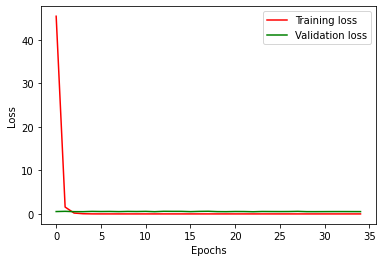

In [8]:
plt.plot(entrainement.history['loss'], color='red', label='Training loss')
plt.plot(entrainement.history['val_loss'],  color='green', label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.show()

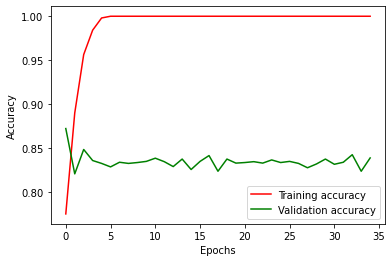

In [9]:
plt.plot(entrainement.history['accuracy'], color='red', label='Training accuracy')
plt.plot(entrainement.history['val_accuracy'],  color='green', label='Validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

plt.show()

In [11]:
from keras.models import Model
from keras.preprocessing import image
import numpy as np

layer_outputs = [layer.output for layer in model.layers]

test_image = "data/test/apple/0014.png"

# Le chargement de l'image doit être augmenté puisque notre model prend des lots d'images.
img = image.load_img(test_image, target_size=(32,32, 1))
img_arr = image.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)

activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_arr)

def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*13.5,col_size*2.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='plasma')

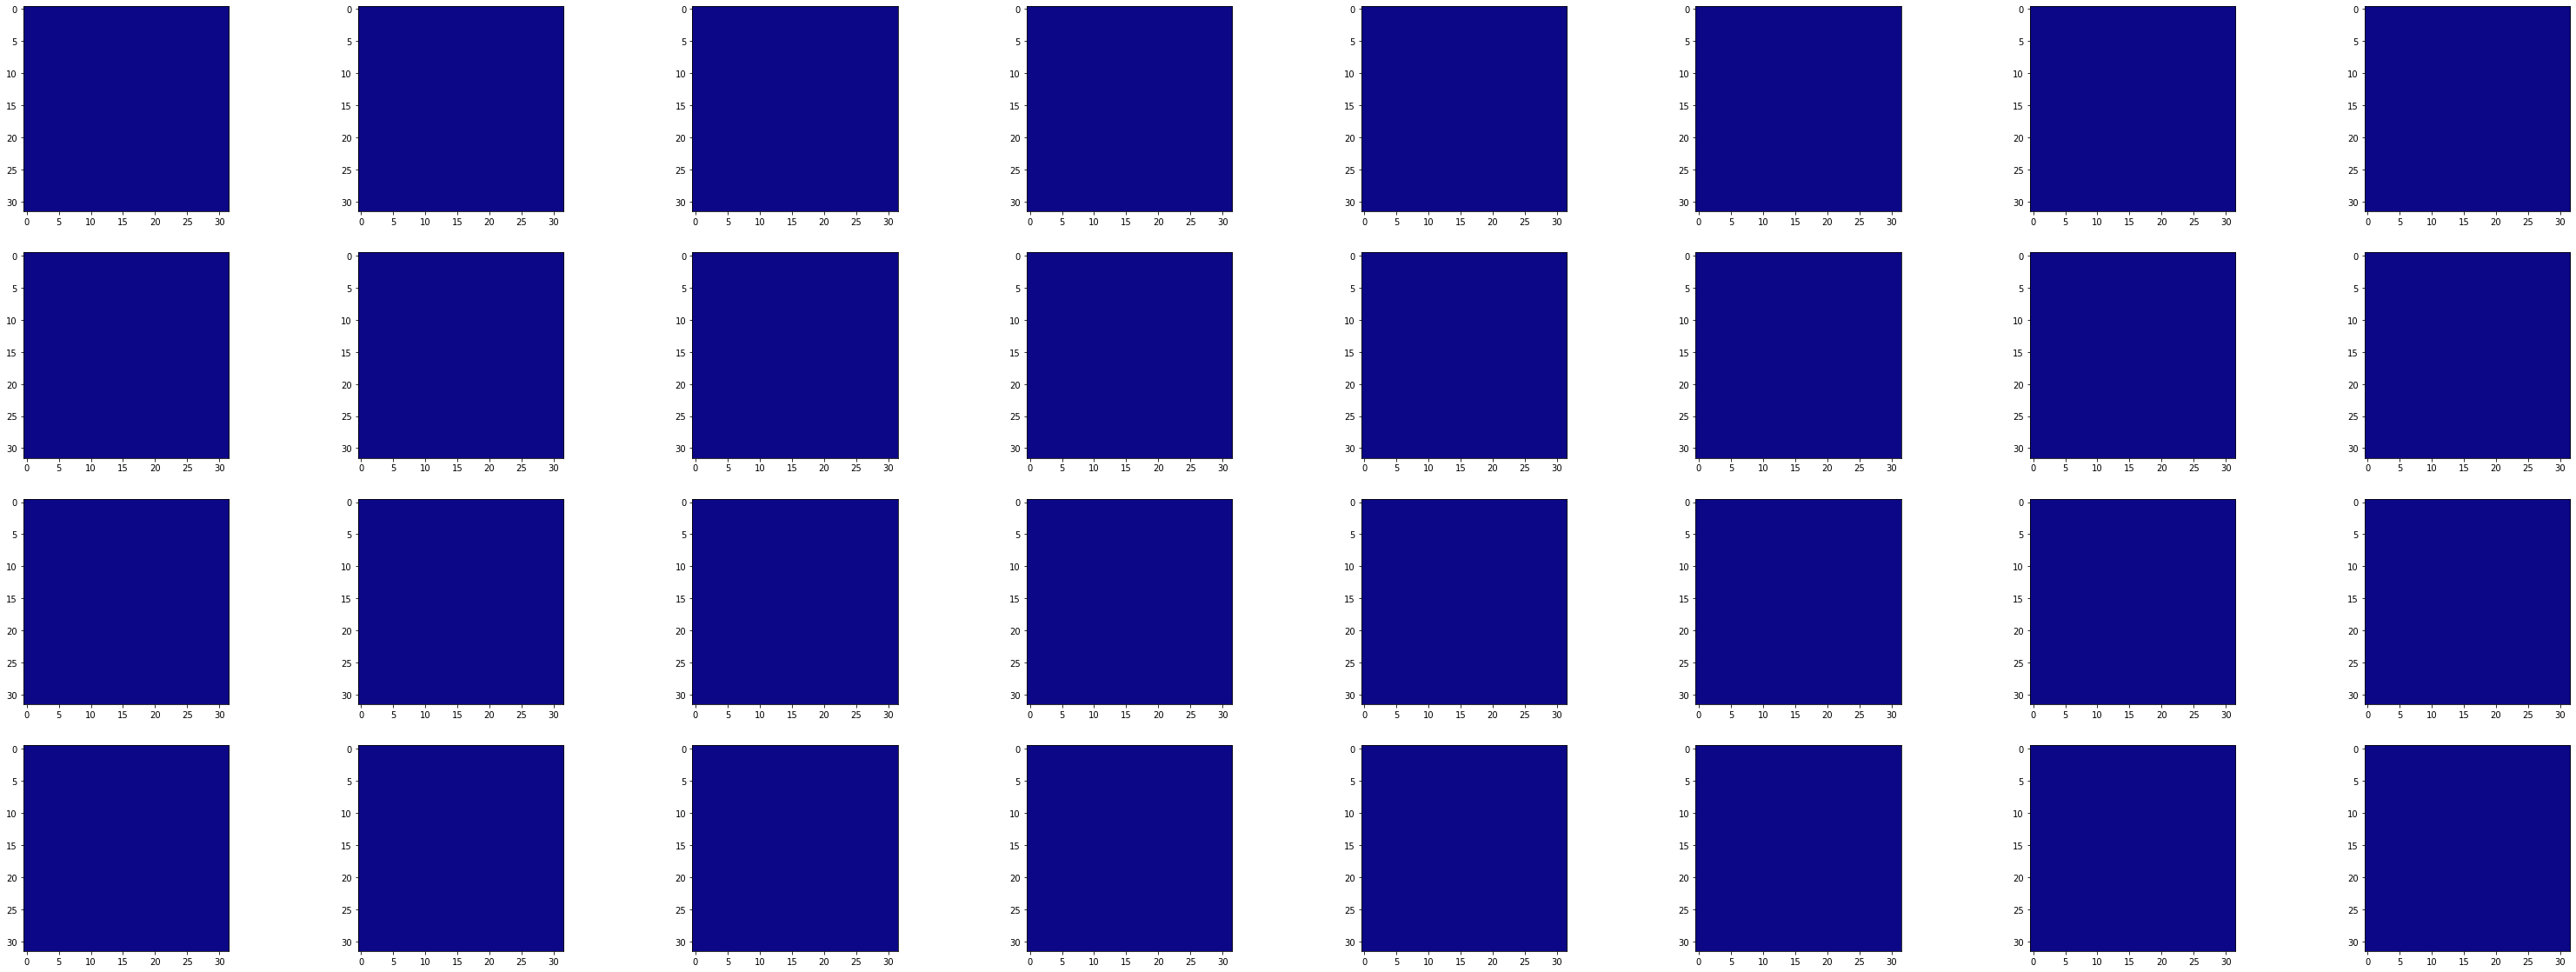

In [12]:
display_activation(activations, 8, 4, 0)

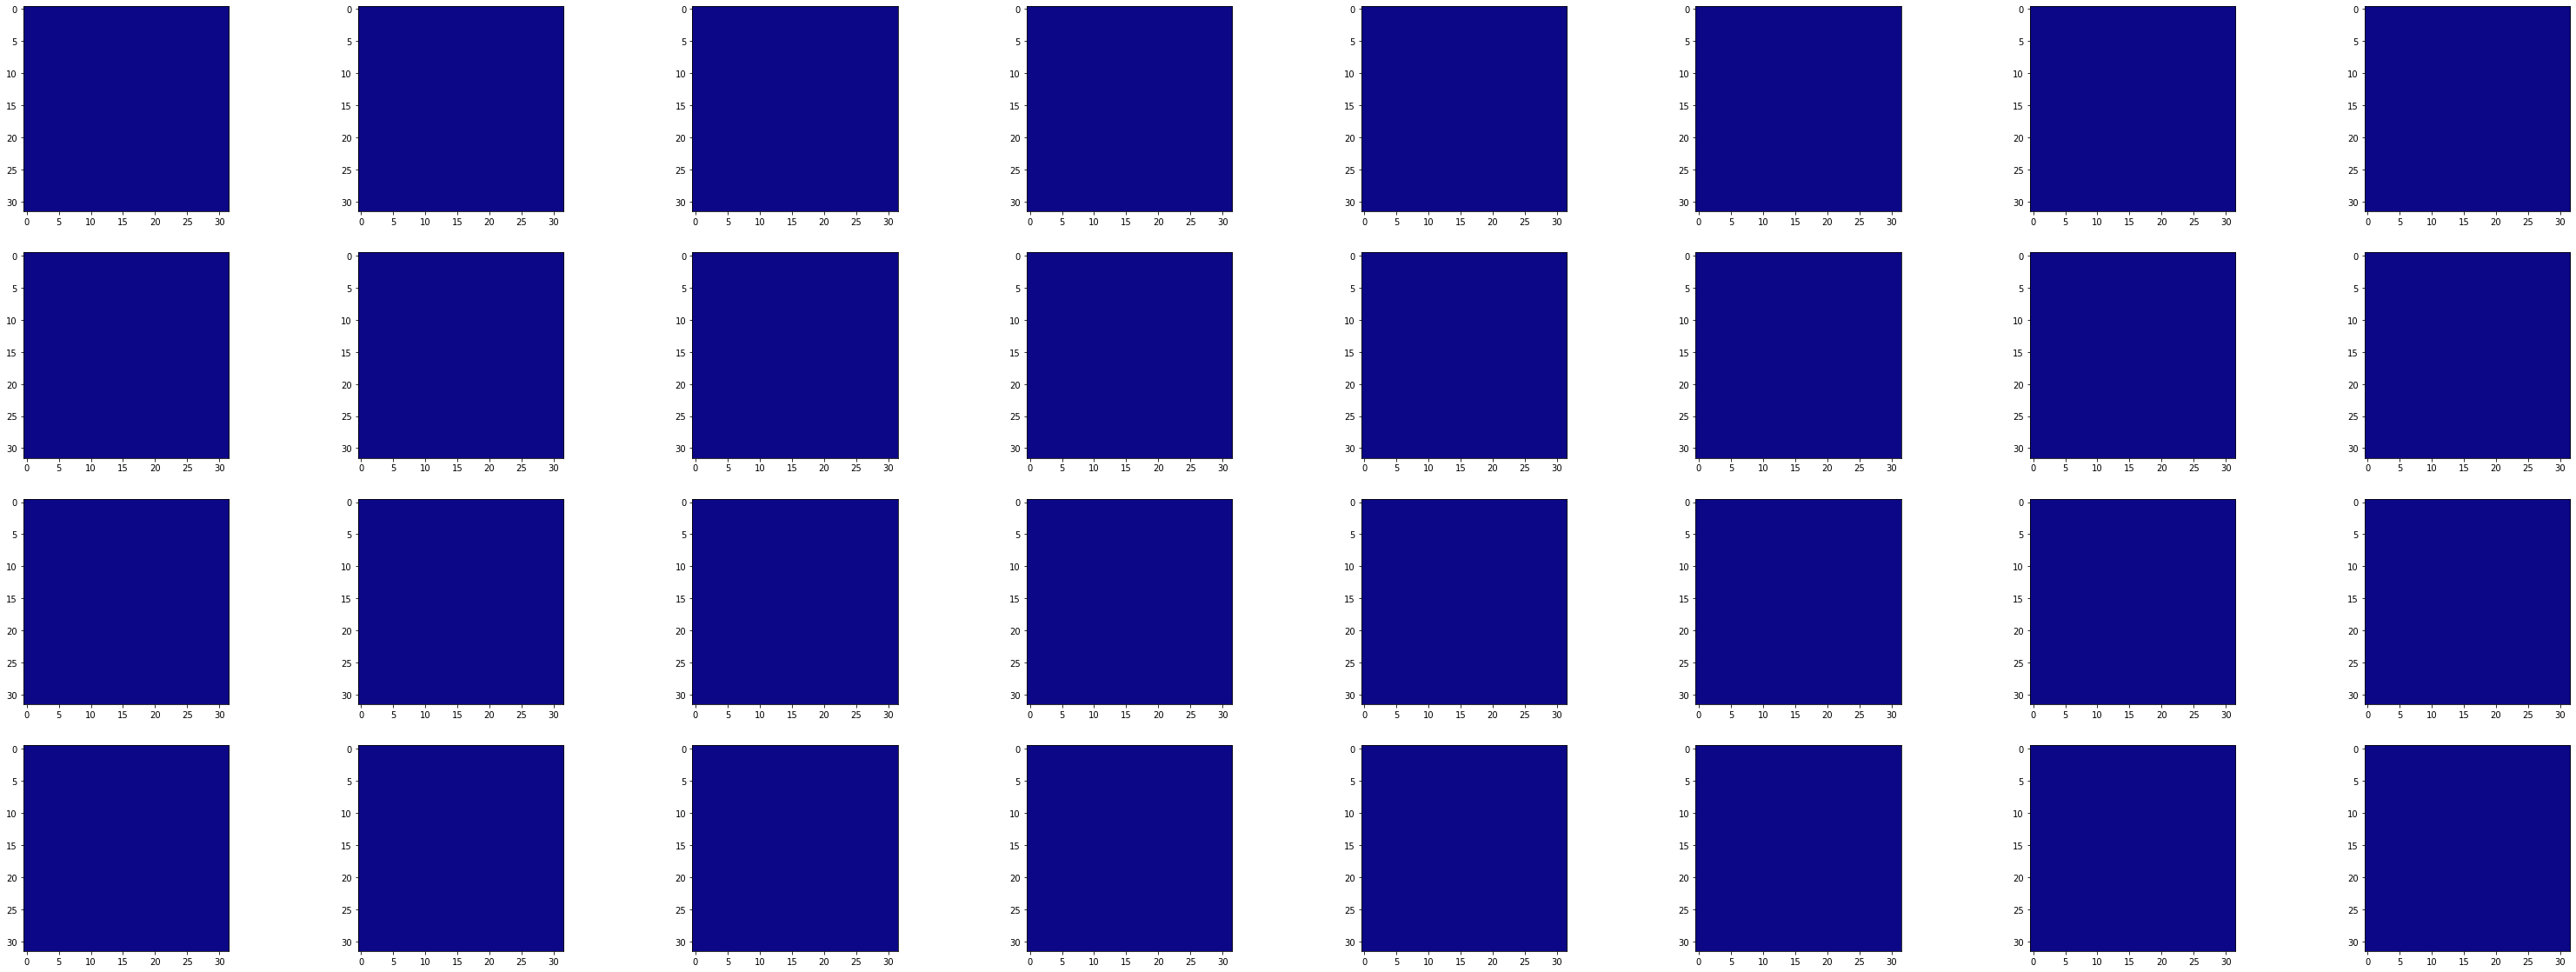

In [13]:
display_activation(activations, 8, 4, 1)